<a href="https://colab.research.google.com/github/Iampushyamithra/Automatic-Image-Captioning/blob/main/Imagecaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## I. Locations of datasets, Paths/ Directories and Importing Drive
The code block below imports drive and stores all the essential paths/directories essential for the Model. This includes: 
1. Importing Drive.
2. Flickr8k Dataset location.
3. Flickr8k Dataset Text location.
4. GloVe Embeddings folder location.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

images_path ='/content/drive/MyDrive/Project Work AI ML/Flicker8k_Dataset'
folder= images_path
img_folder = '/content/drive/MyDrive/Project Work AI ML/Flicker8k_Dataset'


filename = '/content/drive/MyDrive/Project Work AI ML/Flickr8k_text'
text_folder = filename
glove_folder = '/content/drive/MyDrive/Project Work AI ML'
proc_path= '/content/drive/MyDrive/Project Work AI ML/'
proc_folder = proc_path 

Mounted at /content/drive


## II. Packages required

This section below deals with importing the essential packages, which shall be used in the model.


In [ ]:
import string
import os
import matplotlib.pyplot as plt
import pickle as pk
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications import vgg16 
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dropout, Dense, LSTM, Embedding, Add
from keras.preprocessing.text import Tokenizer
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

## III. Loading and Extracting Image features
The section below is to read the text files of Flickr8k Dataset and distinguish between the Training, Test and Dev datasets. The Number of Images in the Train, Test and the Dev dataset is returned to us as the Output.

In [ ]:
# define function to read text file
def load_text(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    text = text.split('\n')
    # close the file
    file.close()
    return text
train_imgs = load_text(os.path.join(text_folder, "Flickr_8k.trainImages.txt"))
test_imgs = load_text(os.path.join(text_folder, "Flickr_8k.testImages.txt"))
dev_imgs = load_text(os.path.join(text_folder, "Flickr_8k.devImages.txt"))

train_imgs = [x for x in train_imgs if x != '']
test_imgs = [x for x in test_imgs if x != '']
dev_imgs = [x for x in dev_imgs if x != '']

print("OUTPUT:")

print("Number of images in Train set: ", len(train_imgs))
print("Number of images in Test set: ", len(test_imgs))
print("Number of images in dev set:", len(dev_imgs))

OUTPUT:
Number of images in Train set:  6000
Number of images in Test set:  1000
Number of images in dev set: 1000


### Testing the Images by their key.
The codeblock below checks whether the images have been loaded according to the respective serial order: The output is the corresponding image to the key/name.

In [ ]:
image999 = train_imgs[999]
image_999 = load_img(os.path.join(img_folder, image999))
plt.imshow(image_999)

KeyboardInterrupt: ignored

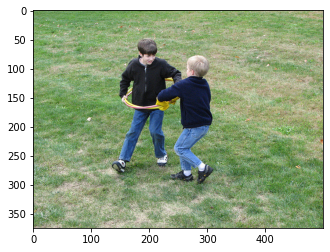

In [ ]:
image799 = train_imgs[799]
image_799 = load_img(os.path.join(img_folder, image799))
plt.imshow(image_799)

### To Extract Image Features of InceptionV3 
 Using **GET_INCEPTION_V3_FEATURE FUNCTION HERE**

In [ ]:
def get_inceptionv3_feature(img_folder, img_name, model):
    # Convert all the images to size 299x299 as expected by the
    # inception v3 model
    img = load_img(os.path.join(img_folder, img_name), target_size=(299,299))
    # Convert PIL image to numpy array of 3-dimensions
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess images using preprocess_input() from inception module
    x = preprocess_input(x)
    x = model.predict(x)
    # reshape from (1, 2048) to (2048, )
    x = np.reshape(x, x.shape[1])
    return x
# Get the InceptionV3 model trained on imagenet data
model_inceptionv3 = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
model_inceptionv3 = Model(model_inceptionv3.input, model_inceptionv3.layers[-2].output)
incv3_features_img999 = get_inceptionv3_feature(img_folder, train_imgs[999], model_inceptionv3)
print("\n")
print("OUTPUT:")
print("\n",'\033[36m' + 'Shape of Image vector for ONE IMAGE:'+'\033[0m', format(incv3_features_img999.shape))


96124928/96112376 [==============================] - 1s 0us/step


OUTPUT:

 Shape of Image vector for ONE IMAGE: (2048,)


Loading and Processing Captions

In [ ]:
filename = '/content/drive/MyDrive/Project Work AI ML/Flickr8k_text'
text_folder = filename

def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc:
        # split line by white space
        tokens = line.split()
        if len(tokens) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        # add 'startseq' and 'endseq' to each description
        image_desc = 'startseq '+' '.join(image_desc) + ' endseq'
        # store the first description for each image
        if image_id not in mapping.keys():
            mapping[image_id] = []
        mapping[image_id].append(image_desc)
    return mapping

    
def clean_description(desc_dict):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in desc_dict.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # store as string
            desc_list[i] =  ' '.join(desc)
descriptions = load_text(os.path.join(text_folder, "Flickr8k.token.txt"))
desc_dict = load_descriptions(descriptions)


# Output the dictionary of descriptions. This prints as a list
print("OUTPUT:")
print("\n",'\033[94m' + '*The first FIVE DESCRIPTIONS GENERATED:' + '\033[0m', "\n",'\033[91m' + '*BEFORE pre-processing*' + '\033[0m',"\n" )

dictionary_items = desc_dict.items()
first_five = list(dictionary_items)[:5]
print(*first_five, sep= "\n")


clean_description(desc_dict)

# Output the dictionary of descriptions with START SEQ AND END SEQ. This prints as a list
print("\n",'\033[94m' + '*The first FIVE DESCRIPTIONS GENERATED:' + '\033[0m', "\n",'\033[91m' + '*AFTER pre-processing*' + '\033[0m', "\n")

dictionary_items = desc_dict.items()
first_five = list(dictionary_items)[:5]
print(*first_five, sep= "\n")



OUTPUT:

 *The first FIVE DESCRIPTIONS GENERATED: 
 *BEFORE pre-processing* 

('1000268201_693b08cb0e', ['startseq A child in a pink dress is climbing up a set of stairs in an entry way . endseq', 'startseq A girl going into a wooden building . endseq', 'startseq A little girl climbing into a wooden playhouse . endseq', 'startseq A little girl climbing the stairs to her playhouse . endseq', 'startseq A little girl in a pink dress going into a wooden cabin . endseq'])
('1001773457_577c3a7d70', ['startseq A black dog and a spotted dog are fighting endseq', 'startseq A black dog and a tri-colored dog playing with each other on the road . endseq', 'startseq A black dog and a white dog with brown spots are staring at each other in the street . endseq', 'startseq Two dogs of different breeds looking at each other on the road . endseq', 'startseq Two dogs on pavement moving toward each other . endseq'])
('1002674143_1b742ab4b8', ['startseq A little girl covered in paint sits in front of a pai

Extracting GlovE Embeddings

In [ ]:
# Create the vocabulary.
vocabulary = set()
for key in desc_dict.keys():
    [vocabulary.update(d.split()) for d in desc_dict[key]]
vocabulary = list(vocabulary)

print('Original Vocabulary Size: %d' % len(vocabulary))
# Create the word <--> index mappers.
# NOTE: index starts from 1, not 0.
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocabulary:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_folder, 'glove.twitter.27B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print("Vocabulary size of GLOVE: {}".format(len(embeddings_index)))

# Get 200-dim dense vector for each of words in vocabulary
embedding_dim = 200
vocab_size = len(vocabulary)+1    # added 1 for padding
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
print("Shape of embedding weights for the current vocabulary {}".format(embedding_matrix.shape))

Original Vocabulary Size: 8810
Vocabulary size of GLOVE: 1193515
Shape of embedding weights for the current vocabulary (8811, 200)


Data generator to prepare input X[i] and target Y[i]
Assume that you have the following prepared from the previous steps:
1. Cleaned image descriptions as a dictionary;
2. InceptionV3 image features as a dictionary;
3. wordtoix mapper
4. Plus the functions defined below.

In [ ]:
list(desc_dict.items())[:4]

[('1000268201_693b08cb0e',
  ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
   'startseq girl going into wooden building endseq',
   'startseq little girl climbing into wooden playhouse endseq',
   'startseq little girl climbing the stairs to her playhouse endseq',
   'startseq little girl in pink dress going into wooden cabin endseq']),
 ('1001773457_577c3a7d70',
  ['startseq black dog and spotted dog are fighting endseq',
   'startseq black dog and tricolored dog playing with each other on the road endseq',
   'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
   'startseq two dogs of different breeds looking at each other on the road endseq',
   'startseq two dogs on pavement moving toward each other endseq']),
 ('1002674143_1b742ab4b8',
  ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
   'startseq little girl is sitting in front of large p

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(desc_dict):
    all_desc = list()
    for key in desc_dict.keys():
        [all_desc.append(d) for d in desc_dict[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)


# define the data generator function
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, descriptions in desc_dict.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in descriptions:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0
import pickle
file_path = '/content/drive/MyDrive/Project Work AI ML/encoded_train_images_new.pkl'
data = pickle.load(open(file_path, "rb"))
num_photos_per_batch =5

batch_generator = data_generator(descriptions=desc_dict,
               photos=data, wordtoix=wordtoix, max_length=max_length, 
               num_photos_per_batch=num_photos_per_batch)

inputs,outputs = next(batch_generator)

print("OUTPUT:")
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)


FileNotFoundError: ignored

In [ ]:
#load training set

filename = '/content/drive/MyDrive/Project Work AI ML/Flickr8k_text'
text_folder = filename
train_imgs = load_text(os.path.join(text_folder, "Flickr_8k.trainImages.txt"))

# Get the InceptionV3 model trained on imagenet data

model = InceptionV3(weights='imagenet')

# Remove the last layer (output softmax layer) from the inception v3

model_new = Model(model.input, model.layers[-2].output)
# define the function
def get_cnn_feature(img_folder, img_name, model):
  # Convert all the images to size 299x299 as expected by the
  # inception v3 model
  img = load_img(os.path.join(img_folder, img_name), target_size=(299,299))
  # Convert PIL image to numpy array of 3-dimensions
  x = img_to_array(img)
  # Add one more dimension
  x = np.expand_dims(x, axis=0)
  # preprocess images using preprocess_input() from inception module
  x = preprocess_input(x)
  x = model.predict(x)
  # reshape from (1, 2048) to (2048, )
  x = np.reshape(x, x.shape[1])
  return x

# extract features for training set:
encoded_training_images = dict()
for img in train_imgs:
  encoded_training_images[img] = get_cnn_feature(img_folder, img, model_new)
  with open(os.path.join(proc_folder, 'encoded_train_images_new.pkl'), 'wb') as f:
    pk.dump(encoded_training_images,f)

In [ ]:
# Obtain the maximum length of the description
all_values = desc_dict.values()
max_value = max(all_values)
print("The Description with the Maximum length is:",max_value)
length_key = len(max_value)
max_length = length_key

print(max_length)
import pickle
file_path = '/content/drive/MyDrive/Project Work AI ML/encoded_train_images_new.pkl'
data = pickle.load(open(file_path, "rb"))
num_photos_per_batch =5
try:
    print(desc_dict["d"])
except KeyError:
    print("KeyError encountered")
    print(desc_dict.get("d"))
batch_generator = data_generator(descriptions=desc_dict,
               photos=data, wordtoix=wordtoix, max_length=max_length, 
               num_photos_per_batch=num_photos_per_batch)
inputs,outputs = next(batch_generator)


print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)



The Description with the Maximum length is: ['startseq young woman dressed in black and another with purple hair hold up signs offering free hugs endseq', 'startseq two girls are holding up signs offering free hugs endseq', 'startseq two people with signs reading free hug are staring with people nearby endseq', 'startseq two women one with purple hair holding signs advertizing free hugs endseq', 'startseq two women with signs that say free hugs endseq']
5
KeyError encountered
None


KeyError: ignored

Define and train model
To define the model, we need four things from the previous steps:
1. embedding_matrix: transfered GloVe weights
2. max_length: the maximal length of the descriptions
3. vocab_size: vocabulary size of descriptions
4. embedding_dim: the word vector dimension

In [ ]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
# decoder (feed forward) model
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# use pre-fixed weights for embeddding layer and not trainable.
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam')

TypeError: ignored

In [ ]:
import os
import pickle as pk
import numpy as np
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dropout, Dense, LSTM, Embedding, Add

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
  all_desc = list()
for key in descriptions.keys():
  [all_desc.append(d) for d in descriptions[key]]
  
return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
  lines = to_lines(descriptions)
  return max(len(d.split()) for d in lines)

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
  X1, X2, y = list(), list(), list()
  n=0

# loop for ever over images
while 1:
  for key, desc_list in descriptions.items():
    n+=1

# retrieve the photo feature
photo = photos[key]
for desc in desc_list:

  # encode the sequence
  seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
  # split one sequence into multiple X, y pairs
for i in range(1, len(seq)):
  # split into input and output pair
  in_seq, out_seq = seq[:i], seq[i]
  # pad input sequence
  in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
  # encode output sequence
  out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
  # store
  X1.append(photo)
  X2.append(in_seq)
  y.append(out_seq)
  # yield the batch data
  if n==num_photos_per_batch:
    yield [[np.array(X1), np.array(X2)], np.array(y)]
    X1, X2, y = list(), list(), list()
    n=0
  if __name__ == '__main__':
    current_wd = os.getcwd()
    print(current_wd)

proc_folder = os.path.join(current_wd, "data/flickr_processed")
with open(os.path.join(proc_folder, "image_descriptions_training.pkl"), 'rb') as f:
  desc_dict = pk.load(f)
with open(os.path.join(proc_folder, 'vocab.pkl'), 'rb') as f:
  vocabulary = pk.load(f)
with open(os.path.join(proc_folder, 'encoded_train_images.pkl'), 'rb') as f:
  encoded_train_images = pk.load(f)
with open(os.path.join(proc_folder, 'embedding_matrix.pkl'), 'rb') as f:
  embedding_matrix = pk.load(f)
  ixtoword = {}
  wordtoix = {}
  ix = 1
for w in vocabulary:
  wordtoix[w] = ix
  ixtoword[ix] = w
  ix += 1
  max_length = max_length(desc_dict)
  print('Max Description Length: %d' % max_length)
  vocab_size = len(vocabulary)+1
  embedding_dim = 200
  num_epoch = 10

# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# use pre-trained weights for embedding layer and non-trainable
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')
model = load_model(os.path.join(proc_folder, 'inceptionv3_trained', "trained_model_1epochs.h5"))

# encoded_train_images
desc_dict_train = {key: desc_dict[key] for key in encoded_train_images.keys()}
train_generator = data_generator(descriptions=desc_dict_train,
photos=encoded_train_images, wordtoix=wordtoix, max_length=max_length,
num_photos_per_batch=32)

for ep in range(2, num_epoch):
  print("run epoch {}".format(ep))
  model.fit_generator(generator=train_generator, steps_per_epoch=len(encoded_train_images), epochs=1)
  model.save(os.path.join(proc_folder, 'inceptionv3_trained', "trained_model_{}epochs.h5".format(ep)))

AttributeError: ignored

In [ ]:
for ep in range(1, num_epoch):
    print("run epoch {}".format(ep))
    model.fit_generator(generator=train_generator, steps_per_epoch=len(encoded_train_images), epochs=1)
    model.save(os.path.join(proc_folder, 'inceptionv3_trained', "trained_model_{}epochs.h5".format(ep)))

Predictions

In [ ]:
def caption_generator_incpt3glove(photo, model, max_length, wordtoix, ixtoword):
    # start with 'stratseq'
    in_text = ['startseq']
    # iterate over the maximal length of description
    for s in range(max_length):
        seq = [wordtoix[i] for i in in_text]
        seq = pad_sequences([seq], maxlen=max_length)[0]
in_put = [np.array([photo]), np.array([seq])]
       
        out_word = model.predict(in_put, verbose=0)
        # convert probability to integer
        out_word = np.argmax(out_word)
        # map ix to word
        out_word = ixtoword[out_word]
        # stop if we cannot map the word
        if out_word is None:
            break
        # append as input for generating the next word
        in_text.append(out_word)
        # stop if we predict the end of the sequence
        if out_word == 'endseq':
            break
    return in_text